<a href="https://colab.research.google.com/github/31grudnia/Deep-Learning-Projects/blob/3-Dog-Cat-Classification/DL_3_Dog_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tansfer-Training** is a DL technique where we use pre-trained model/s. This pre-trained model is trained for one task and can be re-trained for similar task with smaller dataset 

**Work Flow**

Dataset  

-> Image preprocessing 

-> Train Test split 

-> Pretrained MobileNet Model



---



New Image

-> MobileNet mdoel trained on Dog vs Cat

-> Prediction

# **Preparation**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Importing DvsC dataset from kaggle**

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:05<00:00, 148MB/s]
100% 812M/812M [00:05<00:00, 167MB/s]


In [ ]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [ ]:
# Extracting compressed dataset

from zipfile import ZipFile


dataset = "/content/dogs-vs-cats.zip"

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Sucessfully extracted!")

Sucessfully extracted!


In [ ]:
# Extracting compressed subfolder

from zipfile import ZipFile


dataset = "/content/train.zip"

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("Sucessfully extracted!")

Sucessfully extracted!


In [ ]:
import os 

# Counting number of files in train folder

path, dirs, files = next(os.walk("/content/train")) 
file_count = len(files)
print(f"Number of images: {file_count}")

Number of images: 25000


In [ ]:
# Printing name of images

file_names = os.listdir("/content/train")
print(file_names)

#**Preprocessing**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

**Displaying images from dataset**

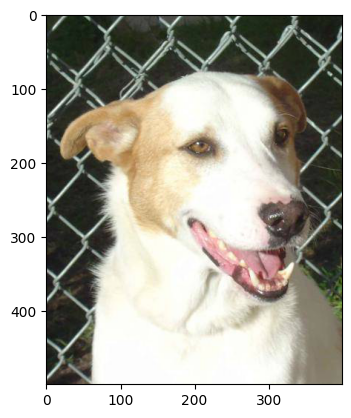

In [ ]:
img = mpimg.imread("/content/train/dog.9832.jpg")
plt.imshow(img)

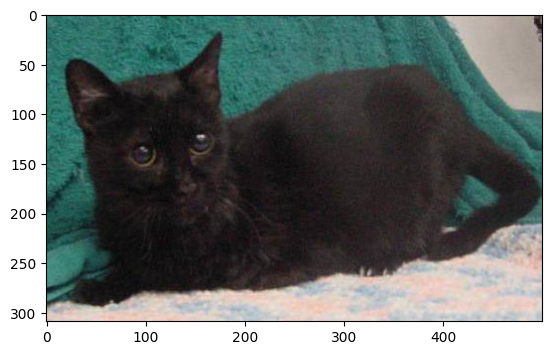

In [ ]:
img = mpimg.imread("/content/train/cat.7008.jpg")
plt.imshow(img)

In [ ]:
file_names = os.listdir("/content/train")

dog_counter = 0
cat_counter = 0

for img_file in file_names:

  name = img_file[0: 3]
  if name == "dog":
    dog_counter += 1 
  else:
    cat_counter += 1 

print(f"Cats: {cat_counter}, Dogs: {dog_counter}")

Cats: 12500, Dogs: 12500


**Resizing Images**

In [ ]:
# Creating directory for resized images

os.mkdir("/content/image_resized")

In [ ]:
original_folder = "/content/train/"
resized_folder = "/content/image_resized/"

for i in range(2000):

  filename = os.listdir(original_folder)[i]
  img_path = original_folder + filename

  img = Image.open(img_path)
  img = img.resize((224, 224)) # model that will be used expects this size of images
  img = img.convert('RGB')

  new_img_path = resized_folder + filename
  img.save(new_img_path)

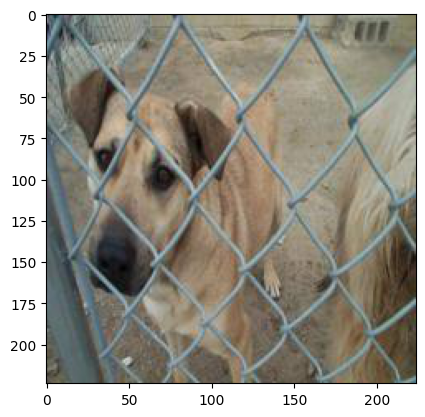

In [ ]:
# Displaying resized pictures

img = mpimg.imread("/content/image_resized/dog.10053.jpg")
plt.imshow(img)

**Creating labels for resized images**

Cat -> 0

Dog -> 1 

In [ ]:
labels = []
path, dirs, files = next(os.walk("/content/image_resized")) 
#print(len(files))
#print(files[1])

for i in range(len(files)):
  file_name = files[i]
  label = file_name[0: 3]

  if label == 'dog':
    labels.append(1)
  else:
    labels.append(0)



In [ ]:
print(labels[0: 5])
print(len(labels))

[0, 0, 1, 1, 1]
2000


In [ ]:
values, counts = np.unique(labels, return_counts=True)
print(f"Values: {values}")
print(f"Counts: {counts}")

Values: [0 1]
Counts: [ 967 1033]


**Converting resized images to np arrays**


In [ ]:
import cv2
import glob

In [ ]:
image_dir = '/content/image_resized/'
image_extentions = ['png', 'jpg', 'jpeg'] 

files = []

[files.extend(glob.glob(image_dir + '*.' + e)) for e in image_extentions]

dog_cat_images = np.asarray([cv2.imread(file) for file in files]) 

In [ ]:
print(dog_cat_images)

In [ ]:
type(dog_cat_images)

numpy.ndarray

In [ ]:
print(dog_cat_images.shape)

(2000, 224, 224, 3)


In [ ]:
X = dog_cat_images
Y = np.asarray(labels)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.2, 
                                                    stratify = Y,
                                                    random_state = 2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(2000, 224, 224, 3) (1600, 224, 224, 3) (400, 224, 224, 3)


**Scaling data**

In [ ]:
X_train_scaled = X_train/255.
X_test_scaled = X_test/255.

In [ ]:
print(X_train_scaled)

# **Building Neural Network**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3), trainable=False)

In [ ]:
num_of_classes = 2

model = tf.keras.Sequential([
    
    pretrained_model,
    tf.keras.layers.Dense(num_of_classes)

])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_5 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
              optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['acc']
)

In [ ]:
model.fit(X_train_scaled, 
          Y_train, 
          epochs = 5)

Epoch 1/5
50/50 [==============================] - 63s 1s/step - loss: 0.1702 - acc: 0.9431
Epoch 2/5
50/50 [==============================] - 71s 1s/step - loss: 0.0730 - acc: 0.9769
Epoch 3/5
50/50 [==============================] - 64s 1s/step - loss: 0.0577 - acc: 0.9825
Epoch 4/5
50/50 [==============================] - 63s 1s/step - loss: 0.0427 - acc: 0.9881
Epoch 5/5
50/50 [==============================] - 57s 1s/step - loss: 0.0357 - acc: 0.9919


In [ ]:
score, acc = model.evaluate(X_test_scaled, Y_test)
print(f"Test loss: {score}")
print(f"Test accuracy : {acc}")

13/13 [==============================] - 18s 1s/step - loss: 0.0784 - acc: 0.9750
Test loss: 0.07839276641607285
Test accuracy : 0.9750000238418579


# **Predictive System**

Path of image to be predicted: /content/train/cat.10897.jpg


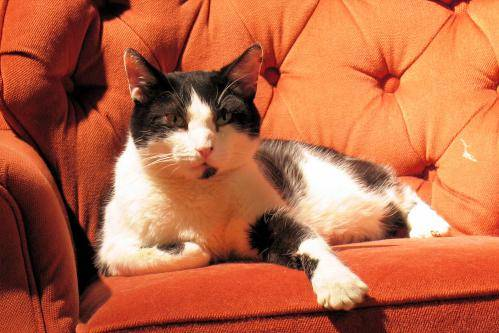

1/1 [==============================] - 1s 521ms/step
It is a CAT!


In [ ]:
input_img_path = input("Path of image to be predicted: ")

input_image = cv2.imread(input_img_path)

cv2_imshow(input_image)

input_image_resize = cv2.resize(input_image, (224, 224))

input_image_scaled = input_image_resize/255.

image_reshaped = np.reshape(input_image_scaled, [1, 224, 224, 3])

input_prediction = model.predict(image_reshaped)

input_pred_label = np.argmax(input_prediction)

if input_pred_label == 0:
  print("It is a CAT!")
else:
  print("It is a DOG!")